In [20]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')
print("RDKit: %s"%rdkit.__version__)


import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


RDKit: 2017.09.3


In [21]:
X_train=np.load('X_train_FSolv_48.npy')
X_test=np.load('X_test_FSolv_48.npy')
y_train_3=np.load('y_train_FSolv_48.npy')
y_test_3=np.load('y_test_FSolv_48.npy')


X_test=np.array(list(X_test))
print(y_test_3.shape)
print(X_test.shape)

(65, 1)
(65, 48, 48, 4)


In [22]:
y_train_orig=np.load('y_train_FSolv_48_orig.npy')
y_test_orig=np.load('y_test_FSolv_48_orig.npy')

In [23]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
y_train_s =  rbs.fit_transform(y_train_orig)
y_test_s = rbs.transform(y_test_orig)

In [24]:
y_train_s.shape

(577, 1)

In [25]:
X_train.shape

(577, 48, 48, 4)

In [26]:
X_train.shape[1:]

(48, 48, 4)

In [27]:
from keras.models import load_model
model = load_model('Chemception_std_notebook_FSolv_48.h5')

In [28]:
check = model.predict(X_train)

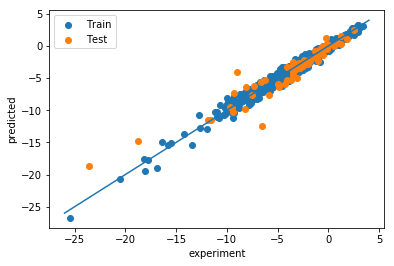

In [30]:
y_pred_t = rbs.inverse_transform(model.predict(X_train))
y_pred = rbs.inverse_transform(model.predict(X_test))
plt.scatter(y_train_orig, y_pred_t, label="Train")
plt.scatter(y_test_orig, y_pred, label="Test")
plt.xlabel("experiment")
plt.ylabel("predicted")
plt.plot([-26,4],[-26,4])
plt.legend()
#plt.savefig("performance2FSolv.png")
#plt.close()

In [31]:
corr2 = np.corrcoef(y_test_orig.reshape(1,-1), y_pred.reshape(1,-1))[0][1]**2
rmse = np.mean((y_test_orig - y_pred)**2)**0.5
print("R2 : %0.2F"%corr2)
print("RMSE : %0.2F"%rmse)


R2 : 0.89
RMSE : 1.50


In [48]:
np.argmin(y_test_s.reshape(1,-1))

58

In [ ]:
y_test_3[]

In [15]:
y_pred[0:5]

array([[ 0.99732041],
       [ 0.08191518],
       [-2.00953603],
       [-0.50597948],
       [-1.90481341]], dtype=float32)

In [36]:
corrCOEF=np.corrcoef(y_test_3.reshape(1,-1), y_pred.reshape(1,-1))

In [37]:
corrCOEF

array([[ 1.        ,  0.95180386],
       [ 0.95180386,  1.        ]])

In [ ]:
y_test_s.reshape(1,-1)

In [ ]:
y_pred.reshape(1,-1)

In [27]:
print(X_test.shape)

(65, 80, 80, 4)


In [28]:
from scipy import stats

In [30]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_s.reshape(1,-1), y_pred.reshape(1,-1))

c:\users\takedatn\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\users\takedatn\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\takedatn\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\takedatn\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
c:\users\takedatn\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.

In [31]:
r_value**2

0.90593059626289985

In [32]:
data = pd.read_csv('SAMPL.csv')


In [33]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

In [34]:
data['mol'] = data["smiles"].apply(Chem.MolFromSmiles)

,iupac,smiles,expt,calc,mol
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,"<img src="""" alt=""Mol""/>"
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,"<img src="""" alt=""Mol""/>"
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,"<img src="""" alt=""Mol""/>"
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,"<img src="""" alt=""Mol""/>"
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,"<img src="""" alt=""Mol""/>"

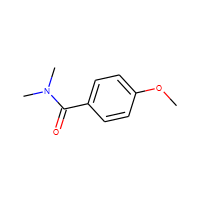
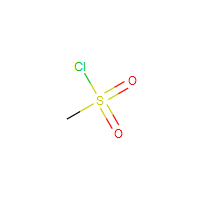
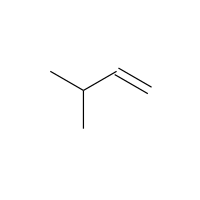
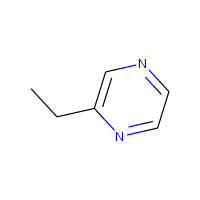
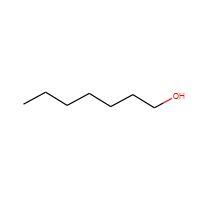

In [35]:
data.head()

iupac                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
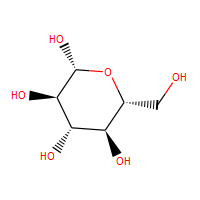

In [36]:
data.iloc[362,:]

(80, 80, 4)


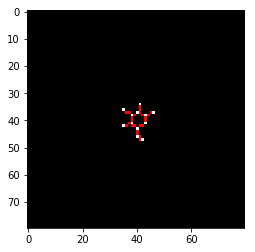

In [37]:
mol = data["mol"][362]
v = chemcepterize_mol(mol)
print(v.shape)
plt.imshow(v[:,:,:3])

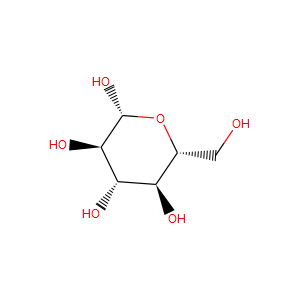

In [39]:
from rdkit.Chem import Draw
Draw.MolToImage(mol)

In [40]:
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12)
data["molimage"] = data["mol"].apply(vectorize)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 6 columns):
iupac       642 non-null object
smiles      642 non-null object
expt        642 non-null float64
calc        642 non-null float64
mol         642 non-null object
molimage    642 non-null object
dtypes: float64(2), object(4)
memory usage: 30.2+ KB


In [42]:
molimage = np.array(list(data["molimage"][362:363]))

In [43]:
molimage.shape

(1, 48, 48, 4)

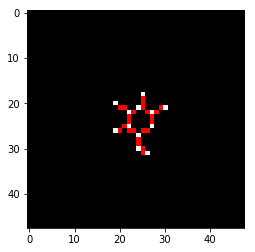

In [44]:
plt.imshow(molimage[0,:,:,:3])

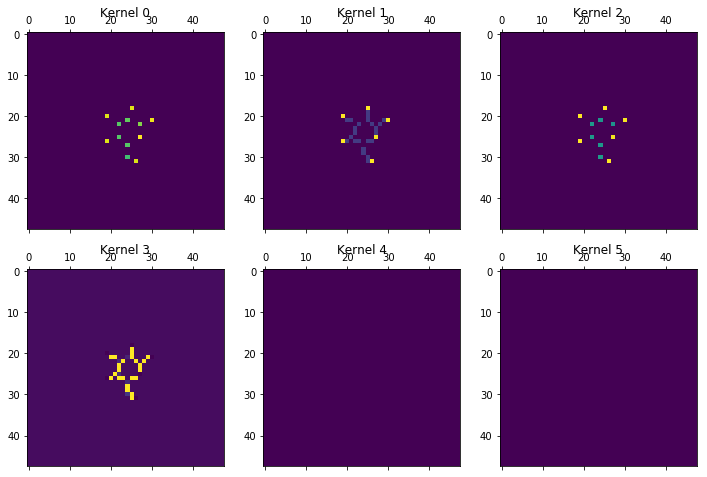

In [45]:
layer1_model = Model(inputs=model.input,
                    outputs=model.layers[2].output)
 
kernels1 = layer1_model.predict(molimage)[0]
 
def plot_kernels(kernels):
    fig, axes = plt.subplots(2,3, figsize=(12,8))
    for i,ax in enumerate(axes.flatten()):
        ax.matshow(kernels[:,:,i])
        ax.set_title("Kernel %s"%i)
 
plot_kernels(kernels1)

Layer 7


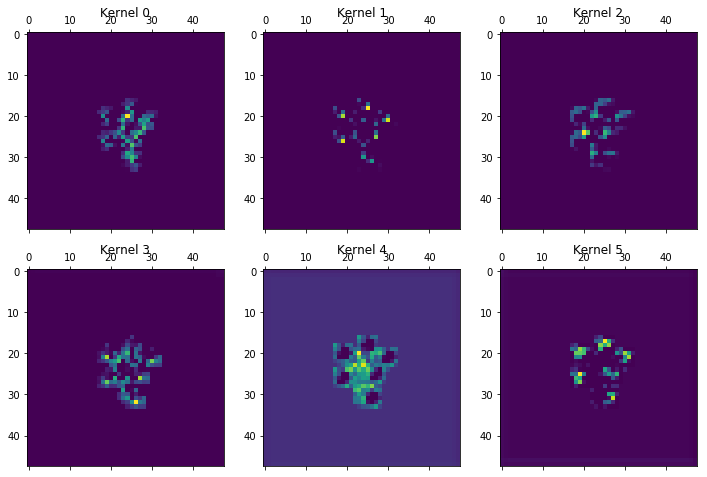

Layer 13


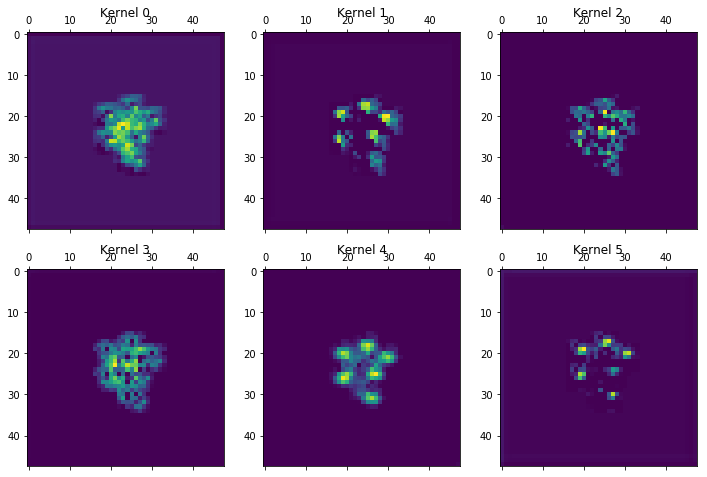

Layer 15


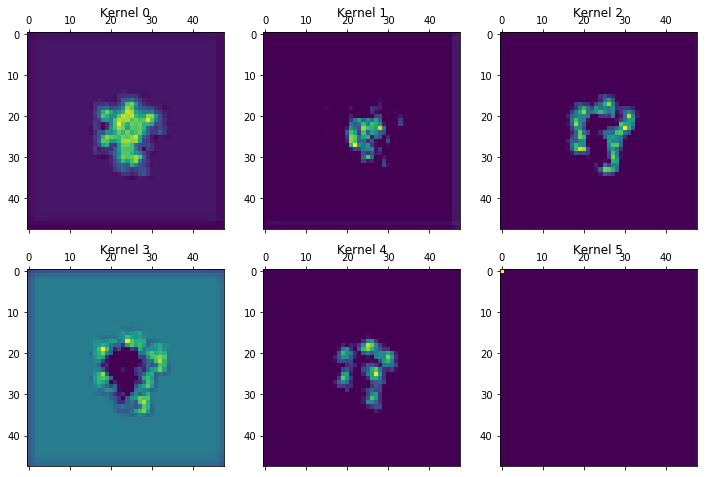

Layer 19


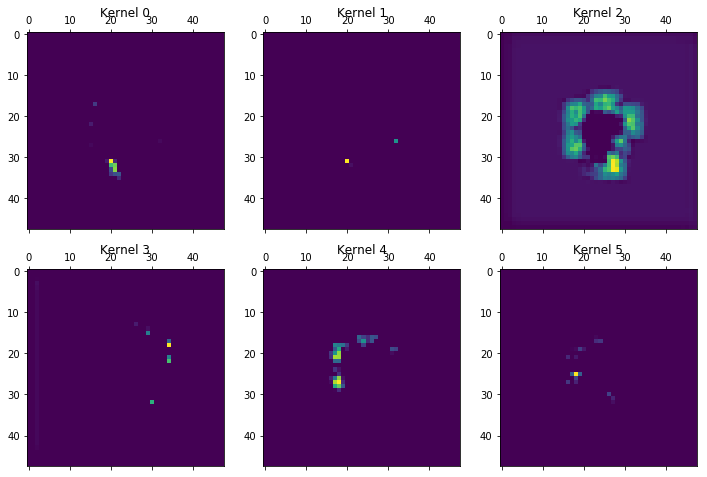

Layer 20


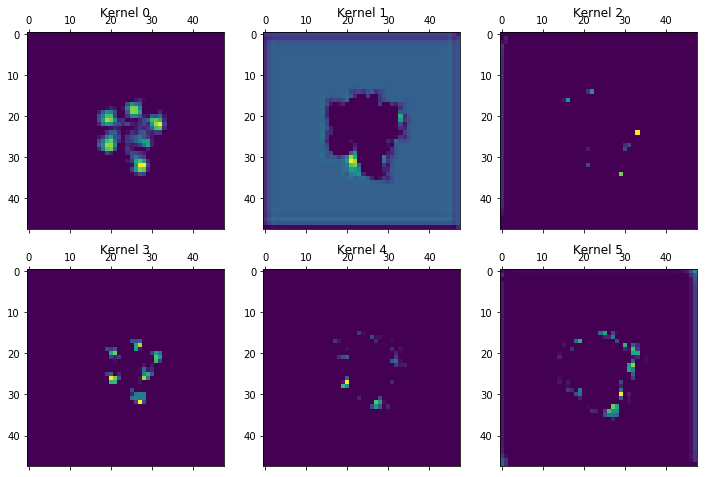

In [46]:
for layer in [7,13,15,19,20]:
    print("Layer %i"%layer)
    plot_kernels(Model(inputs=model.input,outputs=model.layers[layer].output).predict(molimage)[0])
    plt.show()

In [48]:
molnum = 517
molimage = np.array(list(data["molimage"][molnum:molnum+1]))
mol = data["mol"][molnum]

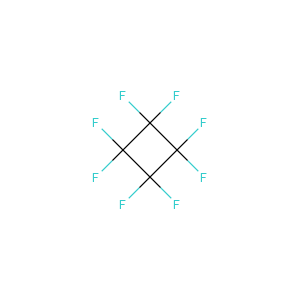

In [49]:
from rdkit.Chem import Draw
Draw.MolToImage(mol)

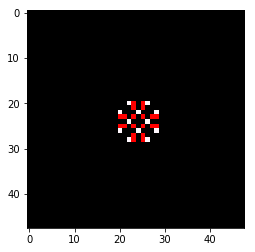

In [50]:
plt.imshow(molimage[0,:,:,:3])

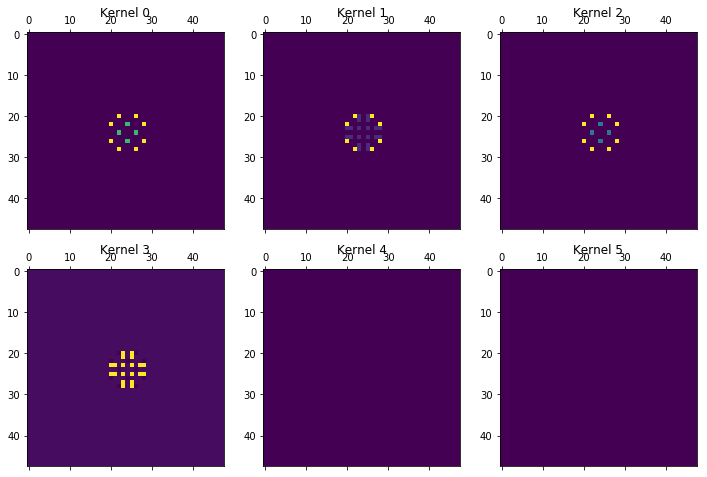

In [51]:
layer1_model = Model(inputs=model.input,
                    outputs=model.layers[2].output)
 
kernels1 = layer1_model.predict(molimage)[0]
 
def plot_kernels(kernels):
    fig, axes = plt.subplots(2,3, figsize=(12,8))
    for i,ax in enumerate(axes.flatten()):
        ax.matshow(kernels[:,:,i])
        ax.set_title("Kernel %s"%i)
 
plot_kernels(kernels1)

Layer 7


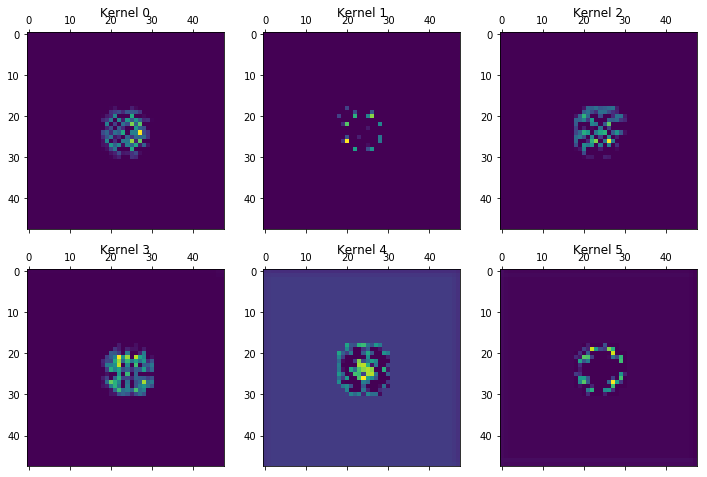

Layer 13


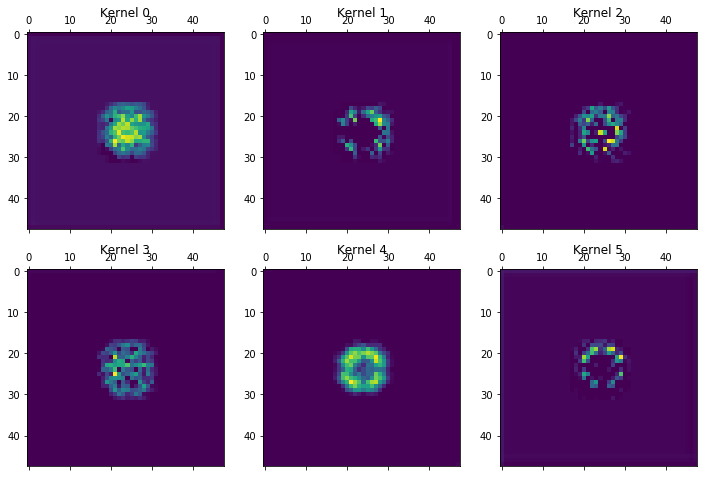

Layer 15


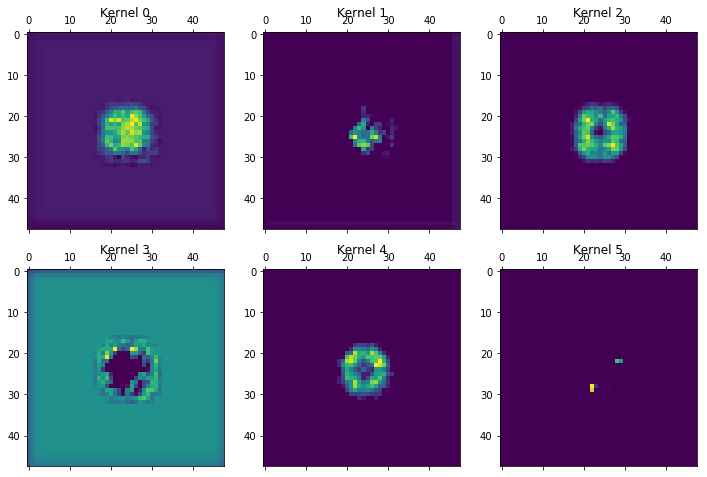

Layer 19


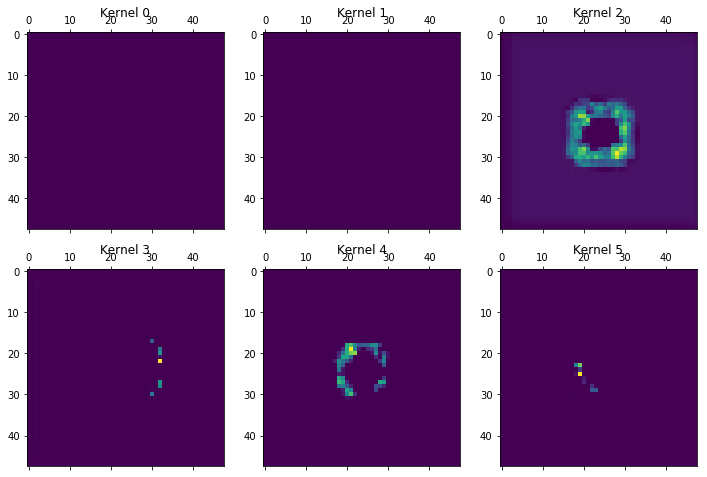

Layer 20


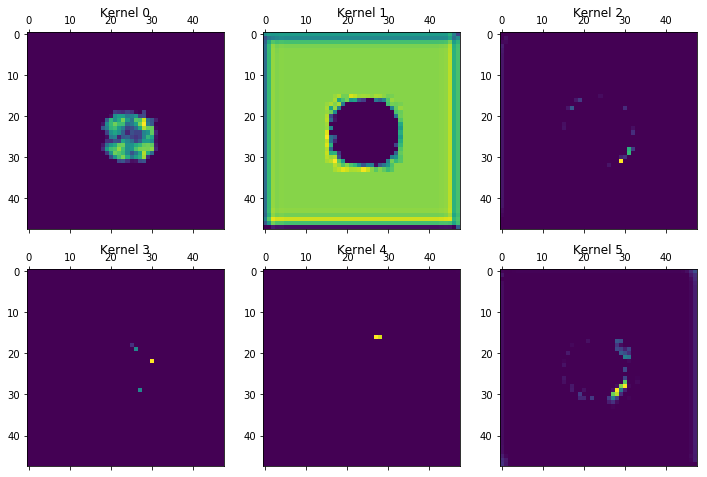

In [52]:
for layer in [7,13,15,19,20]:
    print("Layer %i"%layer)
    plot_kernels(Model(inputs=model.input,outputs=model.layers[layer].output).predict(molimage)[0])
    plt.show()